## МГТУ им. Н. Э. Баумана
## Факультет: Информатика, искусственный интеллект и системы управления
## Кафедра: Системы обработки информации и управления
## Дисциплина: Методы машинного обучения
## Лабораторная работа №3 "Обработка признаков (часть 2)"
## Выполнил: Богданов Д. А. ИУ5-24М

Задание:

1. Выбрать один или несколько наборов данных (датасетов) для решения следующих задач. Каждая задача может быть решена на отдельном датасете, или несколько задач могут быть решены на одном датасете. Просьба не использовать датасет, на котором данная задача решалась в лекции.
2. Для выбранного датасета (датасетов) на основе материалов лекций решить следующие задачи:
 - масштабирование признаков (не менее чем тремя способами);
 - обработку выбросов для числовых признаков (по одному способу для удаления выбросов и для замены выбросов);
 - обработку по крайней мере одного нестандартного признака (который не является числовым или категориальным);
 - отбор признаков:
    - один метод из группы методов фильтрации (filter methods);
    - один метод из группы методов обертывания (wrapper methods);
    - один метод из группы методов вложений (embedded methods).

In [59]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import scipy.stats as stats
import six
import sys
from sklearn.impute import SimpleImputer
sys.modules['sklearn.externals.six'] = six
from sklearn.preprocessing import LabelEncoder
import joblib
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings('ignore')




In [12]:
data = pd.read_csv('airline_passenger_satisfaction.csv', sep=",")
data.head()


,ID,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,...,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Satisfaction
0,1,Male,48,First-time,Business,Business,821,2,5.0,3,...,3,5,2,5,5,5,3,5,5,Neutral or Dissatisfied
1,2,Female,35,Returning,Business,Business,821,26,39.0,2,...,5,4,5,5,3,5,2,5,5,Satisfied
2,3,Male,41,Returning,Business,Business,853,0,0.0,4,...,3,5,3,5,5,3,4,3,3,Satisfied
3,4,Male,50,Returning,Business,Business,1905,0,0.0,2,...,5,5,5,4,4,5,2,5,5,Satisfied
4,5,Female,49,Returning,Business,Business,3470,0,1.0,3,...,3,4,4,5,4,3,3,3,3,Satisfied


Масштабирование признаков


In [13]:
data['Age'].describe()

count    129880.000000
mean         39.427957
std          15.119360
min           7.000000
25%          27.000000
50%          40.000000
75%          51.000000
max          85.000000
Name: Age, dtype: float64

In [14]:
minMaxScaler = MinMaxScaler()
data['Age_minmax'] = minMaxScaler.fit_transform(data[['Age']])
data['Age_minmax'].describe()

count    129880.000000
mean          0.415743
std           0.193838
min           0.000000
25%           0.256410
50%           0.423077
75%           0.564103
max           1.000000
Name: Age_minmax, dtype: float64

In [15]:
standardScaler = StandardScaler()
data['Age_standard'] = standardScaler.fit_transform(data[['Age']])
data['Age_standard'].describe()


count    1.298800e+05
mean    -6.636190e-16
std      1.000004e+00
min     -2.144805e+00
25%     -8.219928e-01
50%      3.783531e-02
75%      7.653821e-01
max      3.014163e+00
Name: Age_standard, dtype: float64

In [16]:
robustScaler = RobustScaler()
data['Age_robust'] = robustScaler.fit_transform(data[['Age']])
data['Age_robust'].describe()

count    129880.000000
mean         -0.023835
std           0.629973
min          -1.375000
25%          -0.541667
50%           0.000000
75%           0.458333
max           1.875000
Name: Age_robust, dtype: float64

Обработка выбросов

In [17]:
def diagnostic_plots(df, variable):
 fig, ax = plt.subplots(figsize=(20,10))
 plt.subplot(2, 2, 1)
 sns.kdeplot(data=data, x=variable)
 ## Q-Q plot
 plt.subplot(2, 2, 2)
 stats.probplot(df[variable], dist="norm", plot=plt)
 # ящик с усами
 plt.subplot(2, 2, 3)
 sns.boxplot(x=df[variable])
 # ящик с усами
 plt.subplot(2, 2, 4)
 df[variable].hist(bins=30)
 plt.show()


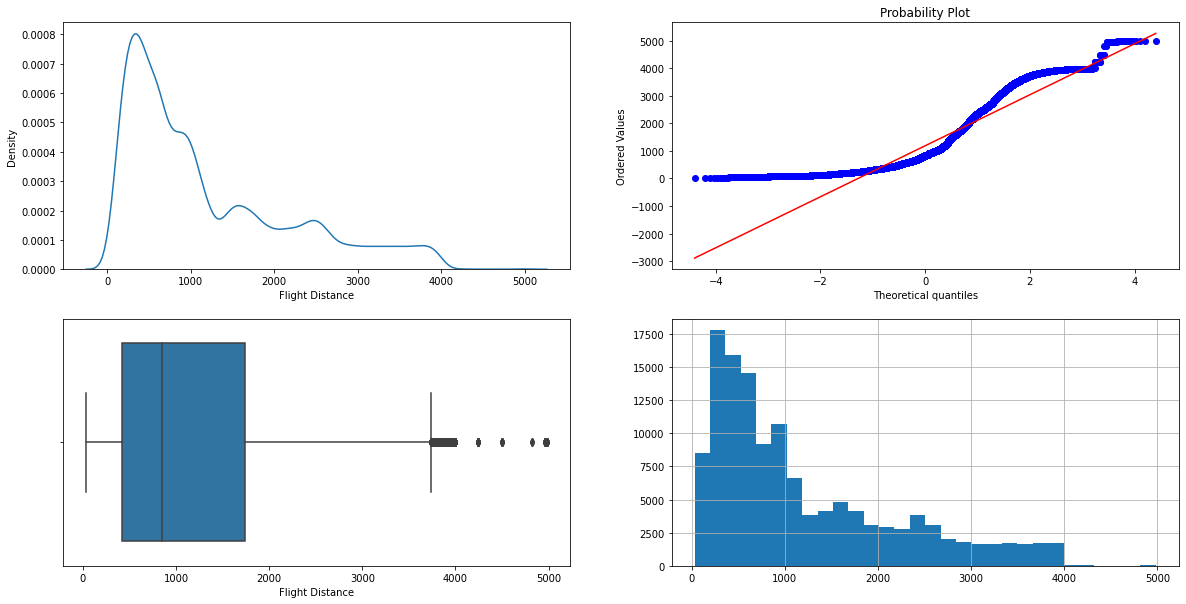

In [18]:
diagnostic_plots(data, 'Flight Distance')


In [19]:
outlierBoundaryType = {
 'SIGMA': 1,
 'QUANTILE': 2,
 'IRQ': 3
}


In [20]:
def get_outlier_boundaries(df, col, outlier_boundary_type):
 if outlier_boundary_type == outlierBoundaryType['SIGMA']:
  K1 = 3
  lower_boundary = df[col].mean() - (K1 * df[col].std())
  upper_boundary = df[col].mean() + (K1 * df[col].std())
 elif outlier_boundary_type == outlierBoundaryType['QUANTILE']:
  lower_boundary = df[col].quantile(0.05)
  upper_boundary = df[col].quantile(0.95)
 elif outlier_boundary_type == outlierBoundaryType['IRQ']:
  K2 = 1.5
  IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
  lower_boundary = df[col].quantile(0.25) - (K2 * IQR)
  upper_boundary = df[col].quantile(0.75) + (K2 * IQR)
 else:
  return 0, 0
 return lower_boundary, upper_boundary

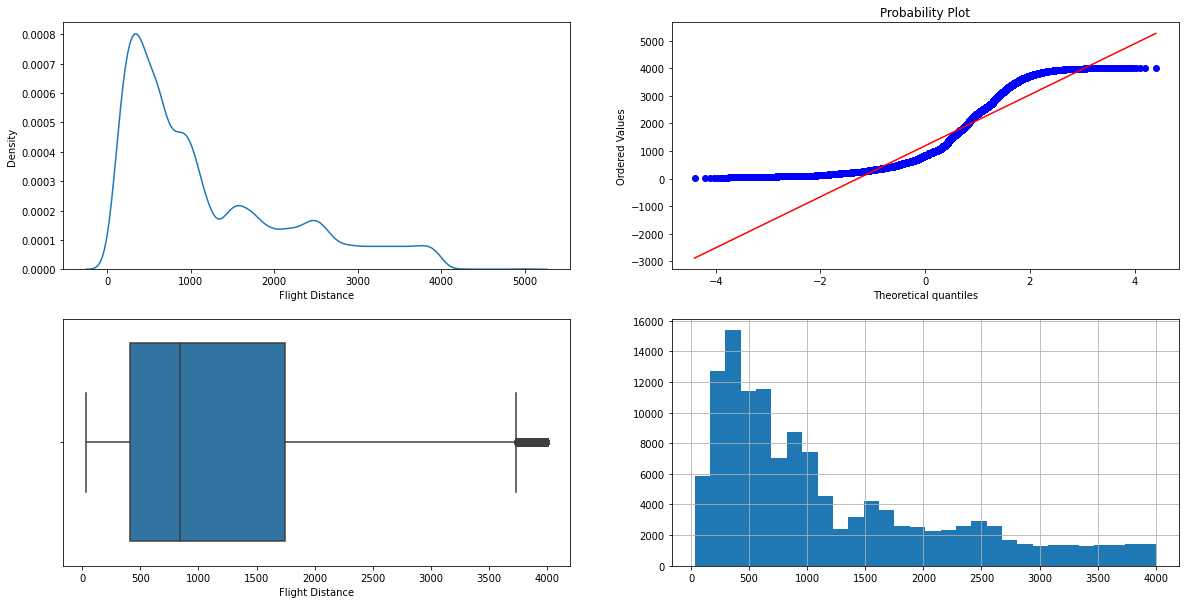

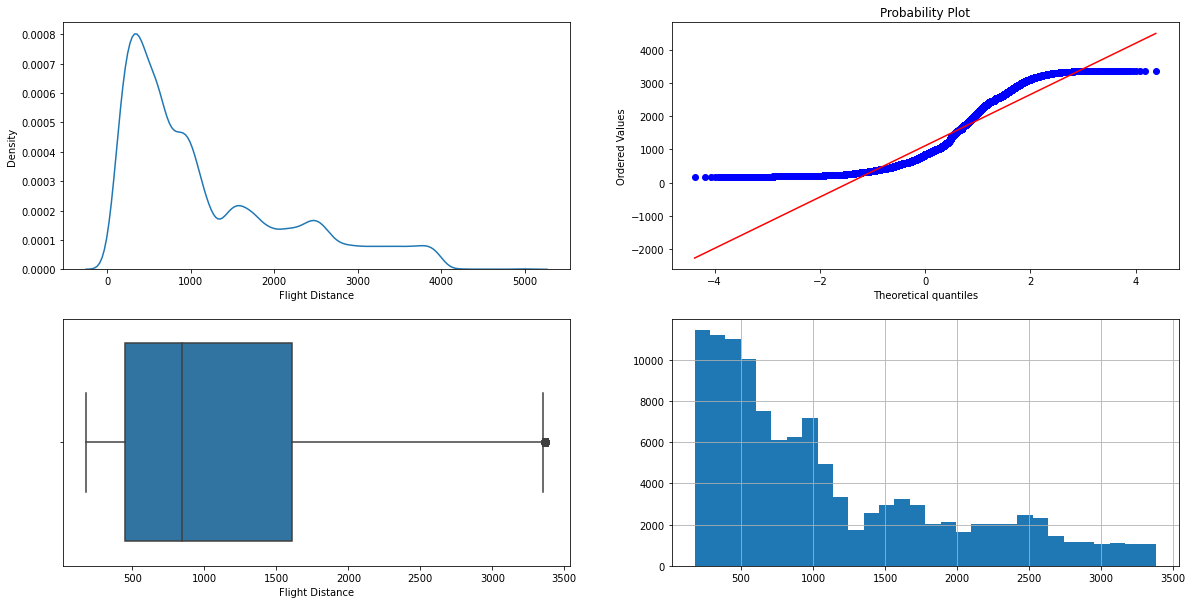

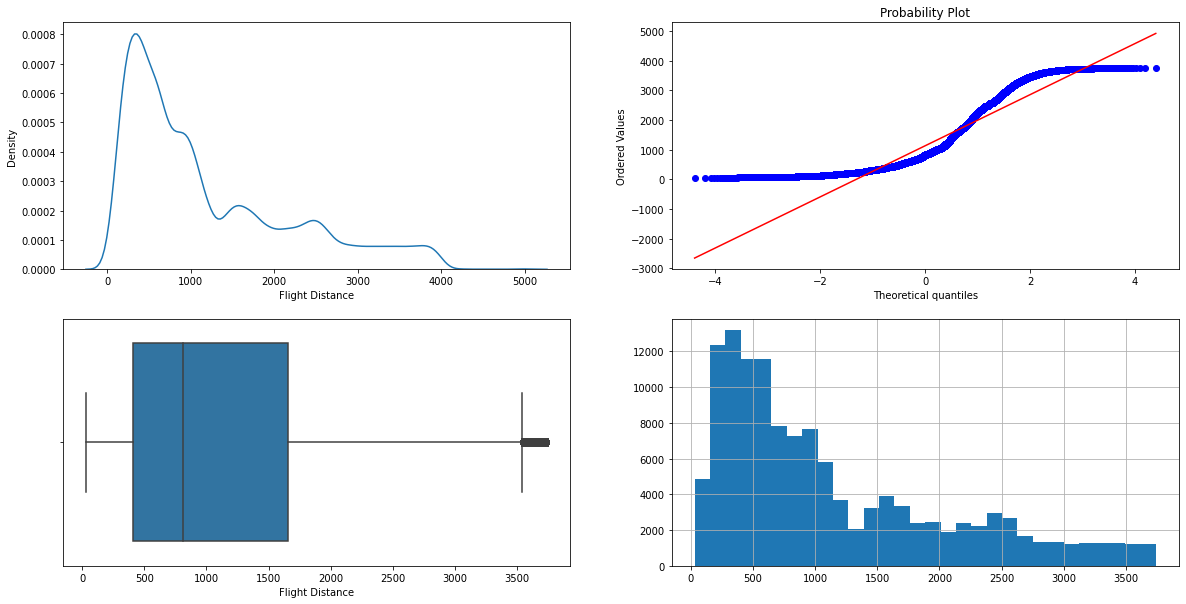

In [21]:
for key, value in outlierBoundaryType.items():
 col = 'Flight Distance'
 lower_boundary, upper_boundary = get_outlier_boundaries(data, col, value)
 outliers_temp = np.where(data[col] > upper_boundary, True, np.where(data[col] < lower_boundary, True, False))
 data_trimmed = data.loc[~(outliers_temp), ]
 diagnostic_plots(data_trimmed, col)

Обработка нестандартного признака

In [40]:
data2 = pd.read_csv('Listings.csv', sep = ",")
data2.head()



,Listing_Id,Posting_Date,Posting_Time,Location,Images,Bookings,Host_Type
0,4955430,13/05/2019,20:18:13,San Francisco,31,10,Regular
1,3338094,04/01/2016,05:30:37,Amsterdam,6,48,Regular
2,3132720,24/12/2018,12:26:15,Barcelona,25,10,Regular
3,3196344,14/10/2014,15:09:27,Berlin,10,134,Superhost
4,4588846,21/07/2016,09:26:48,Brussels,4,7,Regular


In [41]:
# Целевой признак
data2['Location'].value_counts()

Madrid            27
Los Angeles       24
Mexico City       23
Bengaluru         21
Berlin            21
Brussels          21
Kyoto             21
Tunis             20
New Delhi         19
Vancouver         18
Boston            17
Berkeley          17
Seattle           15
New Jersey        15
Toronto           14
Mumbai            13
San Jose          13
Tokyo             13
Paris             12
Roma              11
Barcelona         11
Chennai           11
Miami             11
Amsterdam          9
Chicago            9
Sydney             8
Cambridge          7
New York           7
Shanghai           7
Wellington         6
London             6
Osaka              6
Auckland           5
Cape Town          5
San Francisco      5
San Francisco      5
San Diego          5
Sao Paulo          5
Seoul              5
Milano             5
Rio                4
Cambridge          3
Name: Location, dtype: int64

In [42]:
# Закодируем целевой признак
target_le = LabelEncoder()
data2['Location_le'] = target_le.fit_transform(data2['Location'])
data2['Location_le'].unique(), target_le.inverse_transform(data2['Location_le'].unique())

(array([29,  0,  2,  5,  7, 13, 16, 37, 15, 33, 17, 19, 25, 24, 26, 34, 32,
        27,  3, 21, 11, 31,  4, 18, 23, 22,  6, 36, 14, 28, 40, 20, 38, 39,
        30, 41,  1, 35, 10, 12,  8,  9]),
 array(['San Francisco', 'Amsterdam', 'Barcelona', 'Berlin', 'Brussels',
        'Kyoto', 'Madrid', 'Tokyo', 'Los Angeles', 'Seattle',
        'Mexico City', 'Milano', 'Paris', 'Osaka', 'Rio', 'Seoul',
        'Sao Paulo', 'Roma', 'Bengaluru', 'New Delhi', 'Chennai',
        'San Jose', 'Berkeley ', 'Miami', 'New York', 'New Jersey ',
        'Boston', 'Sydney', 'London', 'San Diego', 'Vancouver', 'Mumbai',
        'Toronto', 'Tunis', 'San Francisco ', 'Wellington', 'Auckland',
        'Shanghai', 'Cape Town', 'Chicago', 'Cambridge', 'Cambridge '],
       dtype=object))

In [43]:
time_hour = []
time_min = []
time_sec = []
for item in data2['Posting_Time']:
 time_hour.append(int(item.split(':')[0]))
 time_min.append(int(item.split(':')[1]))
 time_sec.append(int(item.split(':')[2]))
day = []
month = []
year = []
for item in data2['Posting_Date']:
 day.append(int(item.split('/')[0]))
 month.append(int(item.split('/')[1]))
 year.append(int(item.split('/')[2]))
data2.insert(1, 'Day', day, allow_duplicates=False)
data2.insert(2, 'Month', month, allow_duplicates=False)
data2.insert(3, 'Year', year, allow_duplicates=False)

data2.insert(5, 'Time(Hours)', time_hour, allow_duplicates=False)
data2.insert(6, 'Time(Min)', time_min, allow_duplicates=False)
data2.insert(7, 'Time(Sec)', time_sec, allow_duplicates=False)
data2 = data2.drop(columns='Posting_Date')
data2 = data2.drop(columns='Posting_Time')
data2.head()


,Listing_Id,Day,Month,Year,Time(Hours),Time(Min),Time(Sec),Location,Images,Bookings,Host_Type,Location_le
0,4955430,13,5,2019,20,18,13,San Francisco,31,10,Regular,29
1,3338094,4,1,2016,5,30,37,Amsterdam,6,48,Regular,0
2,3132720,24,12,2018,12,26,15,Barcelona,25,10,Regular,2
3,3196344,14,10,2014,15,9,27,Berlin,10,134,Superhost,5
4,4588846,21,7,2016,9,26,48,Brussels,4,7,Regular,7


Отбор признаков по корреляции


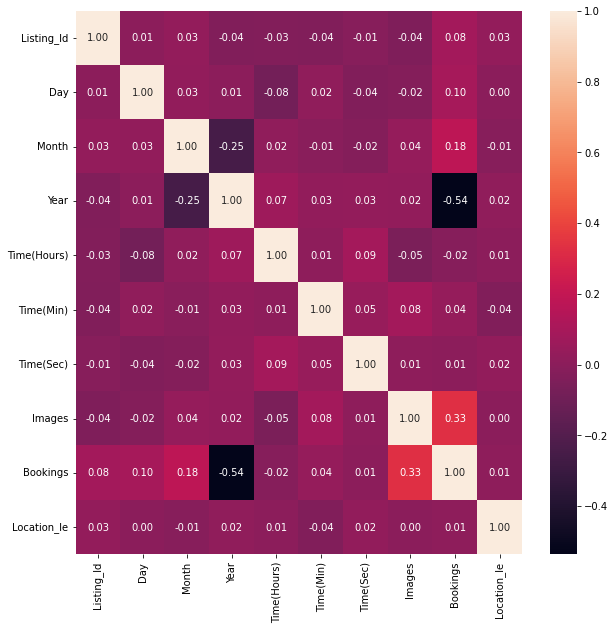

In [44]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data2.corr(method='pearson'), annot=True, fmt='.2f')


In [52]:
for row in data2.corr():
 if data2.corr()[row]['Bookings'] >= 0.3:
  print(row, data2.corr()[row]['Bookings'])

Images 0.3299191634264348
Bookings 1.0


Отбор признаков методом обёртывания


In [56]:
knn = KNeighborsRegressor()
efs1 = EFS(knn,
 min_features=2,
 max_features=4,
 scoring='r2',
 print_progress=True,
 cv=5)
efs1 = efs1.fit(data2.drop(columns=['Bookings']), data2['Bookings'])
print('\nBest accuracy score: %.2f' % efs1.best_score_)
print('Best subset (indices):', efs1.best_idx_)
print('Best subset (corresponding names):', efs1.best_feature_names_)

Features: 550/550


Best accuracy score: 0.44
Best subset (indices): (3, 8)
Best subset (corresponding names): ('Year', 'Images')


Отбор признаков методом вложений


In [68]:
e_lr1 = Lasso()
e_lr1.fit(data2.drop(columns=['Bookings', 'Location', 'Host_Type']), data2['Bookings'])
# Коэффициенты регрессии
e_lr1.coef_

array([ 5.00510688e-06,  6.54025398e-01,  4.34230519e-01, -1.91901583e+01,
        3.11634932e-01,  7.50460659e-02,  6.07083138e-02,  1.99937463e+00,
        8.81710428e-02])

In [69]:
sel_e_lr1 = SelectFromModel(e_lr1)
sel_e_lr1.fit(data2.drop(columns=['Bookings', 'Location', 'Host_Type']), data2['Bookings'])
sel_e_lr1.get_support()

array([False,  True,  True,  True,  True,  True,  True,  True,  True])